In [41]:
!pip install xgboost
!pip install tensorflow

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   - -------------------------------------- 3.1/72.0 MB 13.0 MB/s eta 0:00:06
   --- ------------------------------------ 6.8/72.0 MB 15.6 MB/s eta 0:00:05
   ------ --------------------------------- 11.8/72.0 MB 18.5 MB/s eta 0:00:04
   -------- ------------------------------- 15.5/72.0 MB 18.4 MB/s eta 0:00:04
   ----------- ---------------------------- 20.2/72.0 MB 19.1 MB/s eta 0:00:03
   ------------- -------------------------- 24.9/72.0 MB 19.7 MB/s eta 0:00:03
   ---------------- ----------------------- 29.6/72.0 MB 20.1 MB/s eta 0:00:03
   ------------------ --------------------- 34.1/72.0 MB 20.3 MB/s eta 0:00:02
   --------------------- ------------------ 39.1/72.0 MB 20.7 MB/s eta 0:00:02
   ----------------------- ---------------- 42.5/72.0 MB 20.2 MB/s eta 0:00:02
   -------------------------- ------------- 47.2/72.0 MB 20.5 MB/s eta 0

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [56]:
def preprocess_data(df):
    from sklearn.preprocessing import LabelEncoder
    
    columns = [
        "BsmtFullBath", "GarageQual", "GarageCond", "CentralAir", "GarageType",
        "LotArea", "ExterQual", "LotShape", "GarageYrBlt", "HalfBath", "OpenPorchSF",
        "2ndFlrSF", "WoodDeckSF", "BsmtFinType1", "BsmtFinSF1", "FireplaceQu",
        "HeatingQC", "Foundation", "Fireplaces", "MasVnrArea", "YearRemodAdd",
        "YearBuilt", "TotRmsAbvGrd", "FullBath", "1stFlrSF", "TotalBsmtSF",
        "GarageArea", "GarageCars", "GrLivArea", "OverallQual", "SalePrice"
    ]
    
    df = df[columns]
    
    categorical_cols = df.select_dtypes(include=['object']).columns
    print(f"Categorical columns to encode: {list(categorical_cols)}")
    
    for col in categorical_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category').cat.codes
    
    return df

In [57]:
def load_and_preprocess_data(filepath='housepnrdenemeee.csv'):
    df = pd.read_csv(filepath)
    
    columns = [
        "BsmtFullBath", "GarageQual", "GarageCond", "CentralAir", "GarageType",
        "LotArea", "ExterQual", "LotShape", "GarageYrBlt", "HalfBath", "OpenPorchSF",
        "2ndFlrSF", "WoodDeckSF", "BsmtFinType1", "BsmtFinSF1", "FireplaceQu",
        "HeatingQC", "Foundation", "Fireplaces", "MasVnrArea", "YearRemodAdd",
        "YearBuilt", "TotRmsAbvGrd", "FullBath", "1stFlrSF", "TotalBsmtSF",
        "GarageArea", "GarageCars", "GrLivArea", "OverallQual", "SalePrice"
    ]
    
    missing_cols = [col for col in columns if col not in df.columns]
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        columns = [col for col in columns if col in df.columns]
    
    df = df[columns]
    
    print(f"Original shape: {df.shape}")
    print(f"NaN values before: {df.isna().sum().sum()}")
    
    categorical_cols = df.select_dtypes(include=['object']).columns
    print(f"Categorical columns: {list(categorical_cols)}")
    
    for col in categorical_cols:
        df[col] = pd.factorize(df[col])[0]
    
    df = df.fillna(df.median())
    
    print(f"Processed shape: {df.shape}")
    print(f"NaN values after: {df.isna().sum().sum()}")
    
    return df

In [58]:
def calculate_metrics(y_true, y_pred):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import math
    
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    tmp, n = 0.0, 0
    for i in range(0, len(y_true)):
        if y_true[i] != 0:
            tmp += math.fabs(y_true[i]-y_pred[i])/y_true[i]
            n += 1
    mape_val = float((tmp/n)*100)
    
    n = len(y_true)
    p = 1
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape_val,
        'r2': r2,
        'adjusted_r2': adjusted_r2
    }

In [59]:
def plot_model_comparison(results_df):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    metrics_to_plot = ['mse', 'rmse', 'mae', 'mape', 'r2', 'adjusted_r2']
    titles = ['MSE', 'RMSE', 'MAE', 'MAPE %', 'R²', 'Adjusted R²']
    
    for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
        ax = axes[idx//3, idx%3]
        bars = ax.barh(results_df['Model'], results_df[metric])
        ax.set_xlabel(title)
        ax.set_title(title)
        ax.invert_yaxis()
        
        for bar in bars:
            width = bar.get_width()
            if metric in ['mape']:
                ax.text(width, bar.get_y() + bar.get_height()/2, 
                       f'{width:.2f}%', 
                       ha='left', va='center', fontsize=8)
            else:
                ax.text(width, bar.get_y() + bar.get_height()/2, 
                       f'{width:.4f}', 
                       ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    return fig

In [61]:
print("=" * 80)
print("HOUSE PRICE PREDICTION - COMPARATIVE ANALYSIS")
print("=" * 80)

print("\n1. Loading and preprocessing data...")
df = load_and_preprocess_data('C:/Users/omcka/Downloads/Fall 25/Intro 2 ml Xiang/Execution/Capstone Project/data/train.csv')

X = df.iloc[:, 0:30]
y = df.iloc[:, 30:31]

print(f"\nX shape: {X.shape}, y shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print(f"\nFinal check - Any NaN in X_train: {X_train.isna().any().any()}")
print(f"Final check - Any NaN in y_train: {y_train.isna().any().any()}")

if X_train.isna().any().any() or y_train.isna().any().any():
    print("Warning: NaN values detected! Filling with median...")
    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_train.median())
    y_train = y_train.fillna(y_train.median())
    y_test = y_test.fillna(y_train.median())

all_results = []

HOUSE PRICE PREDICTION - COMPARATIVE ANALYSIS

1. Loading and preprocessing data...
Original shape: (1460, 31)
NaN values before: 1059
Categorical columns: ['GarageQual', 'GarageCond', 'CentralAir', 'GarageType', 'ExterQual', 'LotShape', 'BsmtFinType1', 'FireplaceQu', 'HeatingQC', 'Foundation']
Processed shape: (1460, 31)
NaN values after: 0

X shape: (1460, 30), y shape: (1460, 1)

Train set: 1168 samples
Test set: 292 samples

Final check - Any NaN in X_train: False
Final check - Any NaN in y_train: False


In [62]:
print("\n" + "=" * 80)
print("DATA SCALING FOR NEURAL NETWORK")
print("=" * 80)

from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_np)
X_test_scaled = scaler_X.transform(X_test_np)
y_train_scaled = scaler_y.fit_transform(y_train_np.reshape(-1, 1)).ravel()
y_test_original = y_test_np.copy()  

print(f"X_train scaled mean: {X_train_scaled.mean():.2f}, std: {X_train_scaled.std():.2f}")
print(f"y_train scaled mean: {y_train_scaled.mean():.2f}, std: {y_train_scaled.std():.2f}")


DATA SCALING FOR NEURAL NETWORK
X_train scaled mean: 0.00, std: 1.00
y_train scaled mean: -0.00, std: 1.00


In [63]:
print("\n" + "=" * 80)
print("DATA VALIDATION")
print("=" * 80)

print("\nX_train info:")
print(f"Shape: {X_train.shape}")
print(f"Dtypes: {X_train.dtypes.unique()}")
print(f"Sample values (first row): {X_train.iloc[0].values[:5]}...")

print("\ny_train info:")
print(f"Shape: {y_train.shape}")
print(f"Dtype: {y_train.dtypes}")
print(f"Sample values: {y_train.iloc[:5].values.flatten()}")

print("\nConverting to numpy for compatibility...")
X_train_np = X_train.values
y_train_np = y_train.values.ravel()
print(f"X_train numpy shape: {X_train_np.shape}, dtype: {X_train_np.dtype}")
print(f"y_train numpy shape: {y_train_np.shape}, dtype: {y_train_np.dtype}")


DATA VALIDATION

X_train info:
Shape: (1168, 30)
Dtypes: [dtype('int64') dtype('float64')]
Sample values (first row): [1. 0. 0. 0. 0.]...

y_train info:
Shape: (1168, 1)
Dtype: SalePrice    int64
dtype: object
Sample values: [145000 178000  85000 175000 127000]

Converting to numpy for compatibility...
X_train numpy shape: (1168, 30), dtype: float64
y_train numpy shape: (1168,), dtype: int64


In [64]:
print("\nDebugging data check:")
print(f"X_train shape: {X_train.shape}")
print(f"X_train dtypes:\n{X_train.dtypes}")
print(f"\nFirst 5 rows of X_train:")
print(X_train.head())
print(f"\nAny NaN? {X_train.isna().any().any()}")
print(f"\ny_train shape: {y_train.shape}")
print(f"y_train dtypes:\n{y_train.dtypes}")

X_train_np = X_train.values
y_train_np = y_train.values
print(f"\nX_train numpy shape: {X_train_np.shape}, dtype: {X_train_np.dtype}")
print(f"y_train numpy shape: {y_train_np.shape}, dtype: {y_train_np.dtype}")
print(f"Any NaN in numpy arrays? {np.any(np.isnan(X_train_np)) or np.any(np.isnan(y_train_np))}")

if np.any(np.isnan(X_train_np)) or np.any(np.isnan(y_train_np)):
    print("\nFilling remaining NaN values...")
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    y_train = y_train.fillna(y_train.median())
    y_test = y_test.fillna(y_train.median())


Debugging data check:
X_train shape: (1168, 30)
X_train dtypes:
BsmtFullBath      int64
GarageQual        int64
GarageCond        int64
CentralAir        int64
GarageType        int64
LotArea           int64
ExterQual         int64
LotShape          int64
GarageYrBlt     float64
HalfBath          int64
OpenPorchSF       int64
2ndFlrSF          int64
WoodDeckSF        int64
BsmtFinType1      int64
BsmtFinSF1        int64
FireplaceQu       int64
HeatingQC         int64
Foundation        int64
Fireplaces        int64
MasVnrArea      float64
YearRemodAdd      int64
YearBuilt         int64
TotRmsAbvGrd      int64
FullBath          int64
1stFlrSF          int64
TotalBsmtSF       int64
GarageArea        int64
GarageCars        int64
GrLivArea         int64
OverallQual       int64
dtype: object

First 5 rows of X_train:
      BsmtFullBath  GarageQual  GarageCond  CentralAir  GarageType  LotArea  \
254              1           0           0           0           0     8400   
1066             

In [65]:
print("\n" + "=" * 80)
print("DATA STATISTICS CHECK")
print("=" * 80)

print(f"X_train stats - Min: {X_train_np.min():.2f}, Max: {X_train_np.max():.2f}, Mean: {X_train_np.mean():.2f}")
print(f"y_train stats - Min: {y_train_np.min():.2f}, Max: {y_train_np.max():.2f}, Mean: {y_train_np.mean():.2f}")

print(f"\nExtreme values in y_train (> 500,000): {(y_train_np > 500000).sum()}")
print(f"Percentage of extreme values: {(y_train_np > 500000).sum() / len(y_train_np) * 100:.2f}%")

if y_train_np.max() / y_train_np.min() > 100:  # If range > 100x
    print("\nData is highly skewed, applying log transform...")
    y_train_log = np.log1p(y_train_np)
    y_test_log = np.log1p(y_test_np)
    
    print(f"After log transform - Min: {y_train_log.min():.2f}, Max: {y_train_log.max():.2f}")


DATA STATISTICS CHECK
X_train stats - Min: -1.00, Max: 215245.00, Mean: 730.95
y_train stats - Min: 34900.00, Max: 745000.00, Mean: 181441.54

Extreme values in y_train (> 500,000): 6
Percentage of extreme values: 0.51%


In [71]:
import importlib.util
import sys

def import_module_from_file(filepath, module_name):
    spec = importlib.util.spec_from_file_location(module_name, filepath)
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

print("\n" + "=" * 80)
print("IMPORTING MODULES")
print("=" * 80)

try:
    linear_regression = import_module_from_file('linear_regression.py', 'linear_regression')
    polynomial_regression = import_module_from_file('polynomial_regression.py', 'polynomial_regression')
    neural_network = import_module_from_file('neural_network.py', 'neural_network')
    paper1 = import_module_from_file('paper1_regressions.py', 'paper1_regressions')
    paper2 = import_module_from_file('paper2_xgboost.py', 'paper2_xgboost')
    print("All modules imported successfully")
except Exception as e:
    print(f"Error importing modules: {e}")
    print("\nPlease make sure all .py files are in the same directory:")
    print("1. linear_regression.py")
    print("2. polynomial_regression.py")
    print("3. neural_network.py")
    print("4. paper1_regressions.py")
    print("5. paper2_xgboost.py")


IMPORTING MODULES
All modules imported successfully


In [69]:
print("\n" + "=" * 80)
print("NEW MODELS IMPLEMENTATION")
print("=" * 80)

X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values.ravel()
y_test_np = y_test.values.ravel()

lr_new = linear_regression.LinearRegressionModel(model_type='linear')
lr_result = lr_new.fit(X_train_np, y_train_np)
lr_predictions = lr_new.predict(X_test_np)
lr_metrics = calculate_metrics(y_test_np, lr_predictions)
all_results.append({'Model': 'Linear Regression (New)', **lr_metrics})
print(f"Linear Regression - RMSE: {lr_metrics['rmse']:.2f}, R²: {lr_metrics['r2']:.4f}")

ridge_new = linear_regression.LinearRegressionModel(model_type='ridge', alpha=10.0)
ridge_result = ridge_new.fit(X_train_np, y_train_np)
ridge_predictions = ridge_new.predict(X_test_np)
ridge_metrics = calculate_metrics(y_test_np, ridge_predictions)
all_results.append({'Model': 'Ridge Regression (New)', **ridge_metrics})
print(f"Ridge Regression - RMSE: {ridge_metrics['rmse']:.2f}, R²: {ridge_metrics['r2']:.4f}")

poly_ridge = polynomial_regression.PolynomialRegressionModel(degree=1, model_type='ridge', alpha=1000.0)
poly_ridge_result = poly_ridge.fit(X_train_np, y_train_np)
poly_ridge_predictions = poly_ridge.predict(X_test_np)
poly_ridge_metrics = calculate_metrics(y_test_np, poly_ridge_predictions)
all_results.append({'Model': 'Polynomial Ridge (New)', **poly_ridge_metrics})
print(f"Polynomial Ridge - RMSE: {poly_ridge_metrics['rmse']:.2f}, R²: {poly_ridge_metrics['r2']:.4f}")

print("\nTraining Neural Network (Architecture: [64, 32, 16])...")
nn = neural_network.NeuralNetworkRegressor(layers_config=[64, 32, 16])
nn_result = nn.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=16, verbose=0)
nn_predictions_scaled = nn.predict(X_test_scaled)
nn_predictions = scaler_y.inverse_transform(nn_predictions_scaled.reshape(-1, 1)).ravel()
nn_metrics = calculate_metrics(y_test_original, nn_predictions)
all_results.append({'Model': 'Neural Network (New)', **nn_metrics})
print(f"Neural Network - RMSE: {nn_metrics['rmse']:.2f}, R²: {nn_metrics['r2']:.4f}")


NEW MODELS IMPLEMENTATION

Training LINEAR Regression...
Training completed in 0.00 seconds
Cross-validation RMSE: 37276.18 (±9542.51)
Linear Regression - RMSE: 37042.70, R²: 0.8211

Training RIDGE Regression...
Training completed in 0.00 seconds
Cross-validation RMSE: 37172.02 (±9595.91)
Ridge Regression - RMSE: 36999.39, R²: 0.8215

Training Polynomial Regression (Degree=1, RIDGE)...
Training completed in 0.00 seconds
Cross-validation RMSE: 38087.79 (±10491.37)
Polynomial Ridge - RMSE: 37700.09, R²: 0.8147

Training Neural Network (Architecture: [64, 32, 16])...

Training Neural Network (Architecture: [64, 32, 16])...

Training completed in 21.79 seconds
Neural Network - RMSE: 28193.91, R²: 0.8964


In [72]:
print("\n" + "=" * 80)
print("PAPER 1: COMPREHENSIVE REGRESSION ANALYSIS")
print("=" * 80)

X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
X_test_np = X_test.values if hasattr(X_test, 'values') else X_test
y_train_np = y_train.values.ravel() if hasattr(y_train, 'values') else y_train.ravel()
y_test_np = y_test.values.ravel() if hasattr(y_test, 'values') else y_test.ravel()

paper1_results = paper1.run_paper1_models(X_train_np, y_train_np, X_test_np, y_test_np)
paper1_summary = paper1.get_paper1_metrics_summary(paper1_results)
all_results.extend(paper1_summary)

for model_summary in paper1_summary:
    print(f"{model_summary['Model']} - RMSE: {model_summary['rmse']:.2f}, R²: {model_summary['r2']:.4f}")


PAPER 1: COMPREHENSIVE REGRESSION ANALYSIS

PAPER 1: COMPREHENSIVE REGRESSION ANALYSIS

1. Ridge Regression (with CV)...

2. Linear Regression...

3. Decision Tree...

4. Random Forest...

5. AdaBoost...

6. XGBoost...

Ridge:
  RMSE: 36896.81, R²: 0.8225, MAPE: 13.68%

Linear:
  RMSE: 37042.70, R²: 0.8211, MAPE: 14.06%

Decision Tree:
  RMSE: 34573.07, R²: 0.8442, MAPE: 13.87%

Random Forest:
  RMSE: 29142.04, R²: 0.8893, MAPE: 11.10%

Adaboost:
  RMSE: 37108.92, R²: 0.8205, MAPE: 19.53%

Xgboost:
  RMSE: 30780.16, R²: 0.8765, MAPE: 11.86%
Ridge (Paper 1) - RMSE: 36896.81, R²: 0.8225
Linear (Paper 1) - RMSE: 37042.70, R²: 0.8211
Decision Tree (Paper 1) - RMSE: 34573.07, R²: 0.8442
Random Forest (Paper 1) - RMSE: 29142.04, R²: 0.8893
Adaboost (Paper 1) - RMSE: 37108.92, R²: 0.8205
Xgboost (Paper 1) - RMSE: 30780.16, R²: 0.8765


In [74]:
print("\n" + "=" * 80)
print("PAPER 2: XGBOOST OPTIMIZATION STUDY")
print("=" * 80)

paper2_results = paper2.run_paper2_xgboost(X_train_np, y_train_np, test_size=0.2, random_state=42)
paper2_summary = paper2.get_paper2_metrics_summary(paper2_results)
all_results.extend(paper2_summary)

for model_summary in paper2_summary:
    print(f"{model_summary['Model']} - RMSE: {model_summary['rmse']:.2f}, R²: {model_summary['r2']:.4f}")


PAPER 2: XGBOOST OPTIMIZATION STUDY

PAPER 2: XGBOOST OPTIMIZATION STUDY
Training samples: 934
Test samples: 234

1. Base XGBoost Model...

Base XGBoost Metrics:
  MSE: 871192192.00
  RMSE: 29515.97
  MAE: 19117.02
  MAPE: 10.90%
  R²: 0.8652
  Adjusted R²: 0.8646

2. Optimized XGBoost Model...

Optimized XGBoost Metrics:
  MSE: 896023104.00
  RMSE: 29933.65
  MAE: 19215.83
  MAPE: 10.77%
  R²: 0.8614
  Adjusted R²: 0.8608

3. Feature Importance Analysis...

Top 10 Features by Importance:
   1. f29: 5083092746240.0000
   2. f28: 1605674991616.0000
   3. f27: 695742103552.0000
   4. f24: 512095289344.0000
   5. f25: 494268481536.0000
   6. f14: 463581839360.0000
   7. f21: 327925170176.0000
   8. f5: 247051075584.0000
   9. f26: 164448911360.0000
  10. f11: 133596962816.0000

4. Cross-Validation Results...
Cross-validation R²: 83.12% (±4.42%)
XGBoost Base (Paper 2) - RMSE: 29515.97, R²: 0.8652
XGBoost Optimized (Paper 2) - RMSE: 29933.65, R²: 0.8614


In [75]:
print("\n" + "=" * 80)
print("DATA SANITY CHECK")
print("=" * 80)

print(f"Number of models trained: {len(all_results)}")
print(f"Sample metrics structure: {all_results[0].keys() if all_results else 'No results yet'}")

if len(all_results) == 0:
    print("ERROR: No results collected. Check previous cells for errors.")


DATA SANITY CHECK
Number of models trained: 22
Sample metrics structure: dict_keys(['Model', 'mse', 'rmse', 'mae', 'mape', 'r2', 'adjusted_r2'])



COMPREHENSIVE MODEL COMPARISON

All Models Performance (sorted by RMSE):
                      Model          mse         rmse          mae      mape       r2  adjusted_r2
       Neural Network (New) 7.948964e+08 28193.906859 17855.234375 11.146200 0.896367     0.896010
    Random Forest (Paper 1) 8.492586e+08 29142.041559 18283.069475 11.103567 0.889280     0.876554
    Random Forest (Paper 1) 8.492586e+08 29142.041559 18283.069475 11.103567 0.889280     0.876554
     XGBoost Base (Paper 2) 8.711922e+08 29515.965036 19117.023438 10.898717 0.865220     0.864639
XGBoost Optimized (Paper 2) 8.960231e+08 29933.645017 19215.826172 10.772277 0.861378     0.860781
          Xgboost (Paper 1) 9.474182e+08 30780.159844 19566.609375 11.859258 0.876483     0.862285
          Xgboost (Paper 1) 9.474182e+08 30780.159844 19566.609375 11.859258 0.876483     0.862285
       Neural Network (New) 1.081822e+09 32891.067724 19618.218750 11.794149 0.858960     0.858474
    Decision Tree (Paper 1) 1.19529

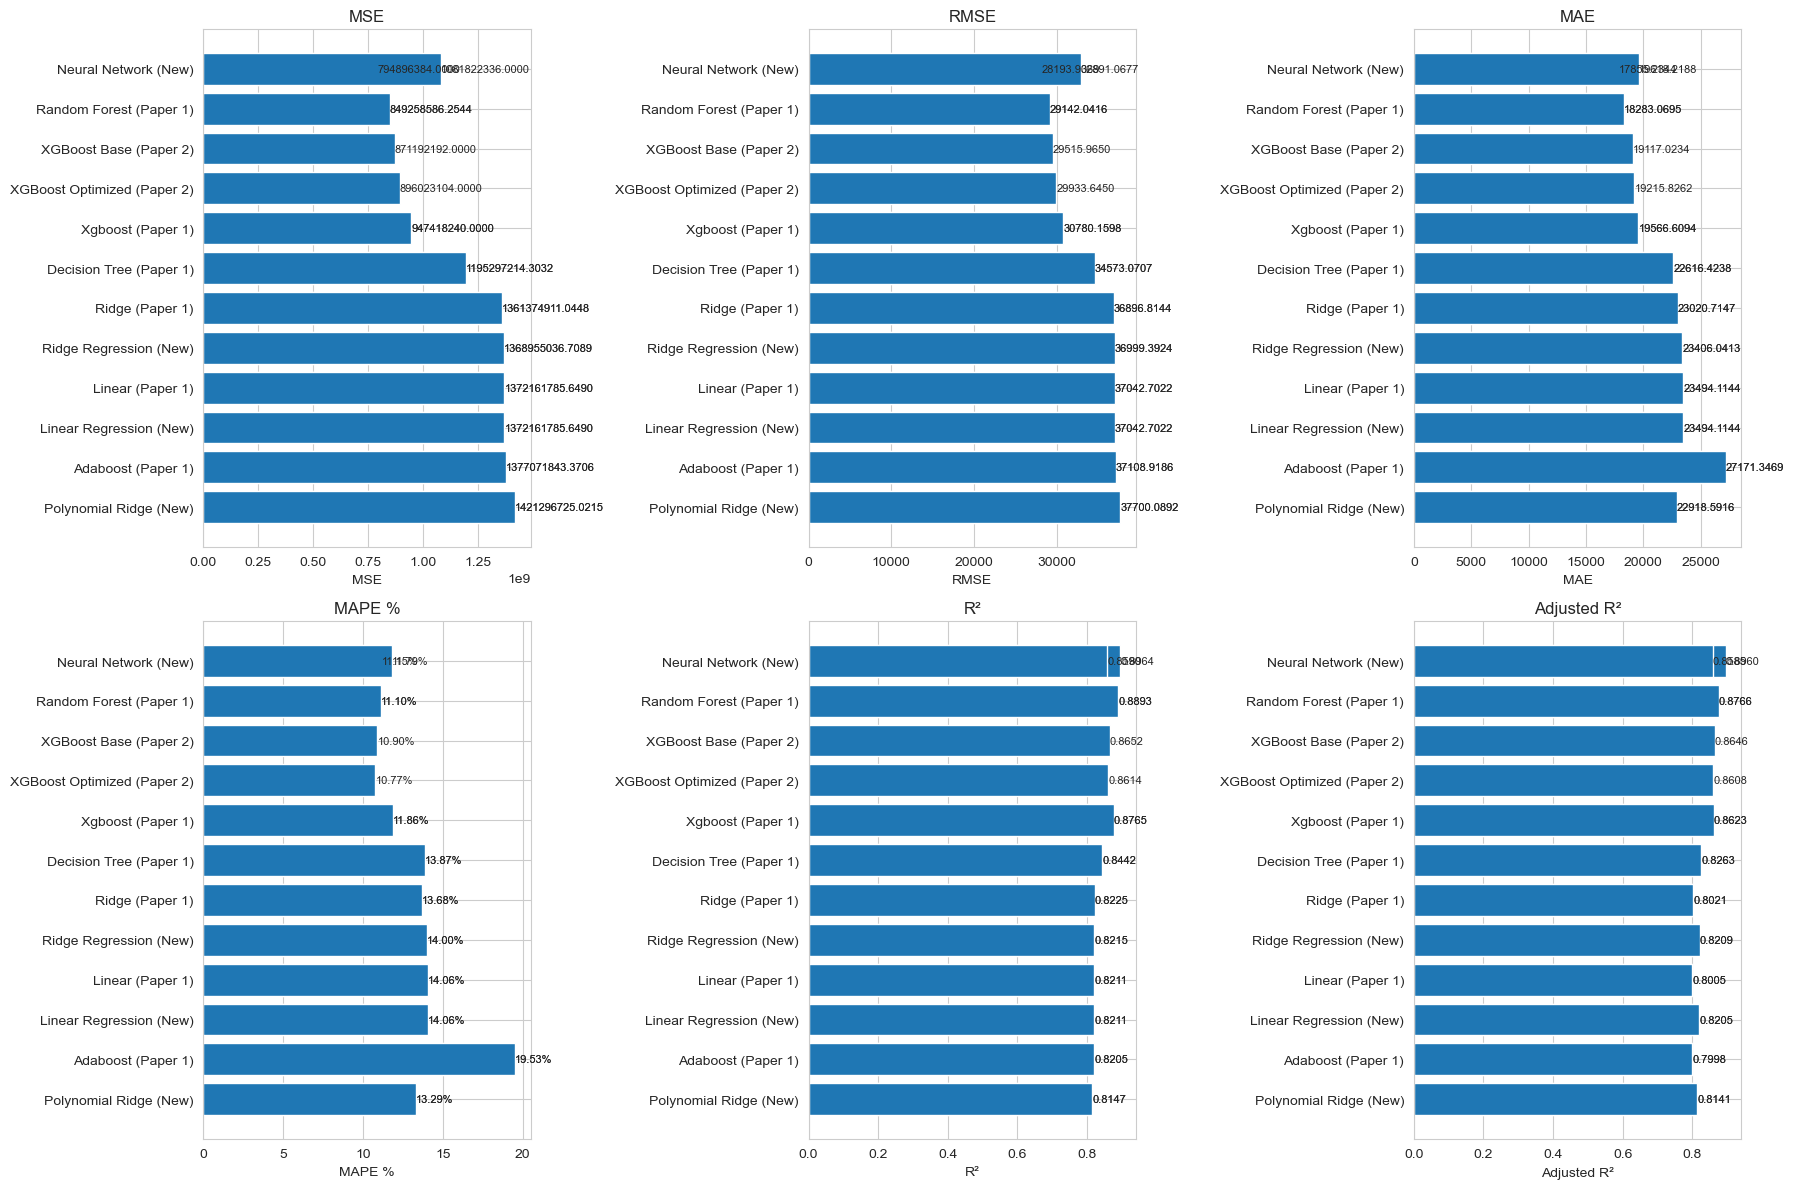


Results saved to 'all_models_comparison.csv'


In [76]:
print("\n" + "=" * 80)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)

results_df = pd.DataFrame(all_results)
column_order = ['Model', 'mse', 'rmse', 'mae', 'mape', 'r2', 'adjusted_r2']
results_df = results_df[column_order]

print("\nAll Models Performance (sorted by RMSE):")
results_df_sorted = results_df.sort_values('rmse')
print(results_df_sorted.to_string(index=False))

print("\nGenerating comparison plots...")
fig = plot_model_comparison(results_df_sorted)
plt.show()

results_df_sorted.to_csv('all_models_comparison.csv', index=False)
print("\nResults saved to 'all_models_comparison.csv'")


PAPER 2 DETAILED ANALYSIS


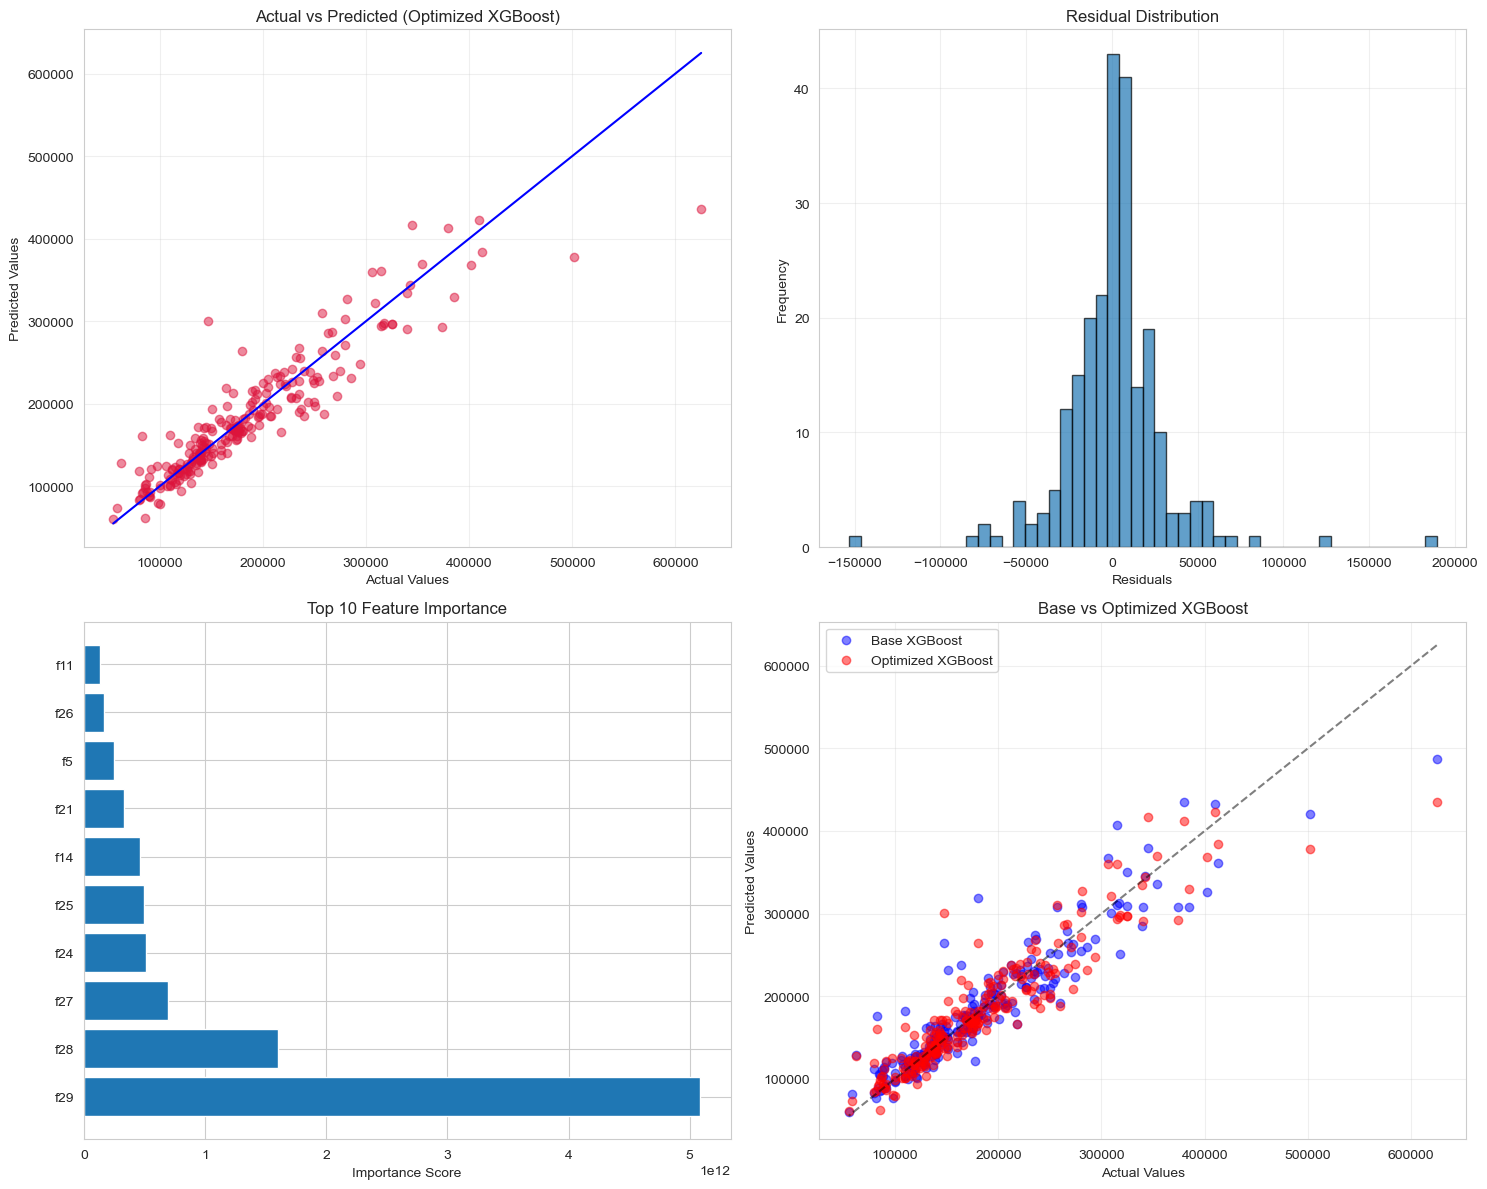

In [77]:
print("\n" + "=" * 80)
print("PAPER 2 DETAILED ANALYSIS")
print("=" * 80)

paper2_fig = paper2.plot_paper2_results(paper2_results)
plt.show()

In [78]:
print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)

print("\nTop 5 Models:")
top_5 = results_df_sorted.head(5)
for idx, row in top_5.iterrows():
    print(f"{idx+1}. {row['Model']}: RMSE={row['rmse']:.2f}, R²={row['r2']:.4f}")


ANALYSIS COMPLETE

Top 5 Models:
8. Neural Network (New): RMSE=28193.91, R²=0.8964
18. Random Forest (Paper 1): RMSE=29142.04, R²=0.8893
12. Random Forest (Paper 1): RMSE=29142.04, R²=0.8893
21. XGBoost Base (Paper 2): RMSE=29515.97, R²=0.8652
22. XGBoost Optimized (Paper 2): RMSE=29933.65, R²=0.8614
